# Tarefa Competição

In [356]:
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
from datetime import datetime
import pickle as pkl

In [357]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn import tree

In [358]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [359]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold

In [360]:
def SaveModel(name, model_name):
    with open(name, "wb") as fd:
        pkl.dump(model_name, fd)

def UseModel(name):
    with open(name, "rb") as fd:
        return pkl.load(fd)

In [361]:
def kaggleMaker(df,model,num):
    kaggle_model = model.predict(df)
    
    # Supondo que kaggle_model seja uma matriz NumPy ou uma série Pandas unidimensional
    kaggle_model = kaggle_model.reshape(-1, 1)  # Reshape para torná-lo bidimensional

    # Criar DataFrame com uma única coluna
    prediction = pd.DataFrame(kaggle_model, columns=["Result"])

    # Adicionar uma coluna "RowId" com índices crescentes
    prediction["RowId"] = range(1, len(prediction) + 1)

    # Reorganizar as colunas
    prediction = prediction[["RowId", "Result"]]
    
    categoria_para_numero = {0:'None' ,  1:'Low', 2:'Medium',  3:'High', 4:'Very High' }
    prediction['Result'] = prediction['Result'].map(categoria_para_numero)
    
    # Salvar o DataFrame em um arquivo CSV
    prediction.to_csv(f"Pred{num}.csv", index=False)

In [362]:
resultados = {}

In [363]:
df0 = pd.read_csv("meteo_202109-202112.csv", na_filter = True)  
df1 = pd.read_csv("meteo_202201-202212.csv", na_filter = True)

df_teste0 =  pd.read_csv ("meteo_202301-202304.csv", na_filter = True)

In [364]:
df_meteo = pd.concat([df0, df1], ignore_index=True)

In [365]:
df_meteo.head()

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain


In [366]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   11688 non-null  int64  
 1   dt_iso               11688 non-null  object 
 2   city_name            11688 non-null  object 
 3   temp                 11688 non-null  float64
 4   feels_like           11688 non-null  float64
 5   temp_min             11688 non-null  float64
 6   temp_max             11688 non-null  float64
 7   pressure             11688 non-null  int64  
 8   sea_level            0 non-null      float64
 9   grnd_level           0 non-null      float64
 10  humidity             11688 non-null  int64  
 11  wind_speed           11688 non-null  float64
 12  rain_1h              2435 non-null   float64
 13  clouds_all           11688 non-null  int64  
 14  weather_description  11688 non-null  object 
dtypes: float64(8), int64(4), object(3)
m

In [367]:
df_meteo.describe()

,dt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all
count,1.168800e+04,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,0.0,0.0,11688.000000,11688.000000,2435.000000,11688.000000
mean,1.651491e+09,16.406638,16.076164,14.433353,17.502990,1018.304073,NaN,NaN,76.619011,2.647688,0.884760,54.258214
std,1.214705e+07,5.715977,6.217605,4.960590,6.112344,6.109727,NaN,NaN,16.157421,1.458574,1.073453,40.443374
min,1.630454e+09,0.320000,-2.190000,-0.640000,1.330000,994.000000,NaN,NaN,19.000000,0.060000,0.100000,0.000000
25%,1.640973e+09,12.350000,11.760000,10.900000,12.930000,1015.000000,NaN,NaN,66.000000,1.610000,0.210000,7.000000
50%,1.651491e+09,15.760000,15.675000,14.540000,16.720000,1018.000000,NaN,NaN,81.000000,2.380000,0.450000,60.000000
75%,1.662009e+09,19.540000,19.560000,17.720000,20.700000,1022.000000,NaN,NaN,91.000000,3.400000,1.070000,98.000000
max,1.672528e+09,40.850000,41.330000,36.720000,41.450000,1034.000000,NaN,NaN,100.000000,11.100000,7.450000,100.000000


In [368]:
df_meteo.nunique()

dt                     11688
dt_iso                 11688
city_name                  1
temp                    2423
feels_like              2702
temp_min                 488
temp_max                 550
pressure                  41
sea_level                  0
grnd_level                 0
humidity                  82
wind_speed               771
rain_1h                  371
clouds_all               101
weather_description        8
dtype: int64

In [369]:
df_teste1 = pd.read_csv("energia_202301-202304.csv", na_filter = False)
df3 = pd.read_csv("energia_202109-202112.csv", na_filter = False)
df4 = pd.read_csv("energia_202201-202212.csv", na_filter = False) # na_filter falso para evitar conversão de None para NaN

In [370]:
df_energia = pd.concat([df3, df4], ignore_index=True)

In [371]:
df_energia.head()

,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),Injecao na rede (kWh)
0,2021-09-29,0,0.0,0.0,0.0,None
1,2021-09-29,1,0.0,0.0,0.0,None
2,2021-09-29,2,0.0,0.0,0.0,None
3,2021-09-29,3,0.0,0.0,0.0,None
4,2021-09-29,4,0.0,0.0,0.0,None


In [372]:
df_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horario Economico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injecao na rede (kWh)    11016 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 516.5+ KB


In [373]:
df_energia.describe()

,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh)
count,11016.000000,11016.000000,11016.000000,11016.000000
mean,11.500000,0.202278,0.159714,0.117314
std,6.922501,0.349478,0.271792,0.176762
min,0.000000,0.000000,0.000000,0.000000
25%,5.750000,0.000000,0.000000,0.000000
50%,11.500000,0.000000,0.000000,0.000000
75%,17.250000,0.314000,0.288000,0.227000
max,23.000000,3.251000,6.978000,1.192000


In [374]:
df_energia.nunique()

Data                        459
Hora                         24
Normal (kWh)               1282
Horario Economico (kWh)     851
Autoconsumo (kWh)           752
Injecao na rede (kWh)         5
dtype: int64

### Juntar os dois Datasets de treino

In [375]:
df_meteo_temp = df_meteo.copy()
df_meteo_temp['dt_iso'] = list ( map(lambda x:( datetime.strptime(x, "%Y-%m-%d %H:%M:%S %z %Z") ).strftime("%Y-%m-%d %H:%M:%S"), df_meteo['dt_iso']) )
df_meteo_temp["dt_iso"] = pd.to_datetime(df_meteo_temp["dt_iso"])
df_meteo_temp

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1630454400,2021-09-01 00:00:00,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11683,1672513200,2022-12-31 19:00:00,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
11684,1672516800,2022-12-31 20:00:00,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
11685,1672520400,2022-12-31 21:00:00,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
11686,1672524000,2022-12-31 22:00:00,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [376]:
df_teste0_temp = df_teste0.copy()
df_teste0_temp['dt_iso'] = list ( map(lambda x:( datetime.strptime(x, "%Y-%m-%d %H:%M:%S %z %Z") ).strftime("%Y-%m-%d %H:%M:%S"), df_teste0_temp['dt_iso']) )
df_teste0_temp["dt_iso"] = pd.to_datetime(df_teste0_temp["dt_iso"])
df_teste0_temp

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1672531200,2023-01-01 00:00:00,local,12.93,12.76,12.72,13.43,1019,NaN,NaN,95,2.02,3.72,100,moderate rain
1,1672534800,2023-01-01 01:00:00,local,13.49,13.38,13.43,13.90,1018,NaN,NaN,95,2.18,3.26,100,moderate rain
2,1672538400,2023-01-01 02:00:00,local,13.55,13.44,13.48,14.82,1017,NaN,NaN,95,2.88,2.44,100,moderate rain
3,1672542000,2023-01-01 03:00:00,local,13.61,13.51,12.01,14.82,1016,NaN,NaN,95,3.63,1.74,100,moderate rain
4,1672545600,2023-01-01 04:00:00,local,13.59,13.49,12.01,14.82,1015,NaN,NaN,95,4.58,1.13,100,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1678820400,2023-03-14 19:00:00,local,13.10,12.27,12.72,13.60,1024,NaN,NaN,69,1.87,NaN,96,overcast clouds
1748,1678824000,2023-03-14 20:00:00,local,12.30,11.83,10.72,12.88,1023,NaN,NaN,86,1.03,NaN,84,broken clouds
1749,1678827600,2023-03-14 21:00:00,local,11.77,11.30,10.26,12.88,1023,NaN,NaN,88,1.03,NaN,84,broken clouds
1750,1678831200,2023-03-14 22:00:00,local,10.68,10.13,9.15,12.32,1023,NaN,NaN,89,1.03,NaN,84,broken clouds


In [377]:
df_final_v0 = pd.merge(df_energia, df_meteo_temp, left_on=['Data', 'Hora'], right_on=[df_meteo_temp['dt_iso'].dt.strftime('%Y-%m-%d'),df_meteo_temp['dt_iso'].dt.hour], how='outer')
df_final_v0


,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),Injecao na rede (kWh),dt,dt_iso,city_name,temp,...,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00,local,13.97,...,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00,local,13.48,...,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00,local,12.93,...,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00,local,12.61,...,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00,local,12.61,...,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11683,2021-09-28,19,NaN,NaN,NaN,NaN,1632855600,2021-09-28 19:00:00,local,16.77,...,15.72,17.32,1026,NaN,NaN,70,3.11,NaN,55,broken clouds
11684,2021-09-28,20,NaN,NaN,NaN,NaN,1632859200,2021-09-28 20:00:00,local,15.67,...,14.72,16.21,1027,NaN,NaN,72,2.97,NaN,70,broken clouds
11685,2021-09-28,21,NaN,NaN,NaN,NaN,1632862800,2021-09-28 21:00:00,local,15.67,...,14.72,15.70,1027,NaN,NaN,72,2.40,NaN,59,broken clouds
11686,2021-09-28,22,NaN,NaN,NaN,NaN,1632866400,2021-09-28 22:00:00,local,14.52,...,12.72,15.11,1027,NaN,NaN,77,2.11,NaN,37,scattered clouds


In [378]:
df_teste_v0 = pd.merge(df_teste1, df_teste0_temp, left_on=['Data', 'Hora'], right_on=[df_teste0_temp['dt_iso'].dt.strftime('%Y-%m-%d'),df_teste0_temp['dt_iso'].dt.hour], how='outer')
df_teste_v0


,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,2023-01-01 00:00:00,local,12.93,12.76,12.72,13.43,1019.0,NaN,NaN,95.0,2.02,3.72,100.0,moderate rain
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,2023-01-01 01:00:00,local,13.49,13.38,13.43,13.90,1018.0,NaN,NaN,95.0,2.18,3.26,100.0,moderate rain
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,2023-01-01 02:00:00,local,13.55,13.44,13.48,14.82,1017.0,NaN,NaN,95.0,2.88,2.44,100.0,moderate rain
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,2023-01-01 03:00:00,local,13.61,13.51,12.01,14.82,1016.0,NaN,NaN,95.0,3.63,1.74,100.0,moderate rain
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,2023-01-01 04:00:00,local,13.59,13.49,12.01,14.82,1015.0,NaN,NaN,95.0,4.58,1.13,100.0,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2252,2023-04-04,20,0.915,0.000,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2253,2023-04-04,21,0.479,0.000,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2254,2023-04-04,22,0.000,0.497,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

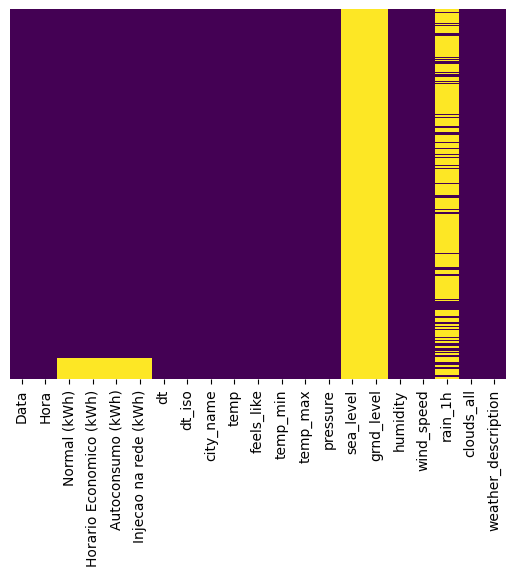

In [379]:
sns.heatmap(df_final_v0.isnull(),yticklabels= False,  cbar = False, cmap = 'viridis')

<Axes: >

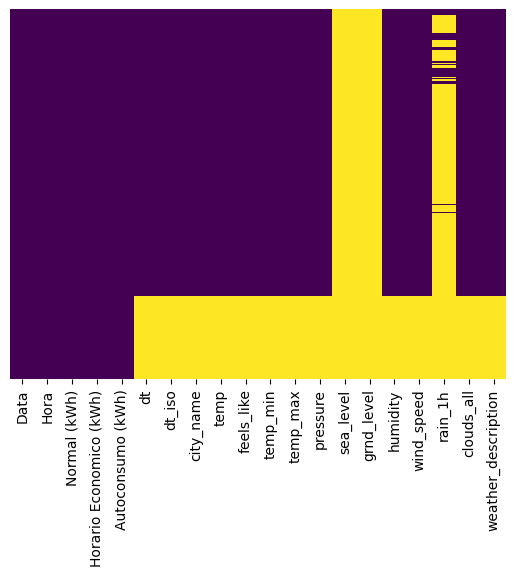

In [380]:
sns.heatmap(df_teste_v0.isnull(),yticklabels= False,  cbar = False, cmap = 'viridis')

In [381]:
df_final_v1 = pd.merge(df_energia, df_meteo_temp, left_on=['Data', 'Hora'], right_on=[df_meteo_temp['dt_iso'].dt.strftime('%Y-%m-%d'),df_meteo_temp['dt_iso'].dt.hour], how='inner')
df_final_v1


,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),Injecao na rede (kWh),dt,dt_iso,city_name,temp,...,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.000,0.000,0.0,None,1632873600,2021-09-29 00:00:00,local,13.97,...,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29,1,0.000,0.000,0.0,None,1632877200,2021-09-29 01:00:00,local,13.48,...,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29,2,0.000,0.000,0.0,None,1632880800,2021-09-29 02:00:00,local,12.93,...,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29,3,0.000,0.000,0.0,None,1632884400,2021-09-29 03:00:00,local,12.61,...,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29,4,0.000,0.000,0.0,None,1632888000,2021-09-29 04:00:00,local,12.61,...,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31,19,1.693,0.000,0.0,None,1672513200,2022-12-31 19:00:00,local,15.70,...,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
11012,2022-12-31,20,1.327,0.000,0.0,None,1672516800,2022-12-31 20:00:00,local,15.55,...,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
11013,2022-12-31,21,0.757,0.000,0.0,None,1672520400,2022-12-31 21:00:00,local,13.45,...,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
11014,2022-12-31,22,0.000,0.675,0.0,None,1672524000,2022-12-31 22:00:00,local,12.93,...,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [382]:
df_teste_v1 = pd.merge(df_teste1, df_teste0_temp, left_on=['Data', 'Hora'], right_on=[ df_teste0_temp['dt_iso'].dt.strftime('%Y-%m-%d'), df_teste0_temp['dt_iso'].dt.hour], how='outer')
df_teste_v1

,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,2023-01-01 00:00:00,local,12.93,12.76,12.72,13.43,1019.0,NaN,NaN,95.0,2.02,3.72,100.0,moderate rain
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,2023-01-01 01:00:00,local,13.49,13.38,13.43,13.90,1018.0,NaN,NaN,95.0,2.18,3.26,100.0,moderate rain
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,2023-01-01 02:00:00,local,13.55,13.44,13.48,14.82,1017.0,NaN,NaN,95.0,2.88,2.44,100.0,moderate rain
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,2023-01-01 03:00:00,local,13.61,13.51,12.01,14.82,1016.0,NaN,NaN,95.0,3.63,1.74,100.0,moderate rain
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,2023-01-01 04:00:00,local,13.59,13.49,12.01,14.82,1015.0,NaN,NaN,95.0,4.58,1.13,100.0,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2252,2023-04-04,20,0.915,0.000,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2253,2023-04-04,21,0.479,0.000,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2254,2023-04-04,22,0.000,0.497,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

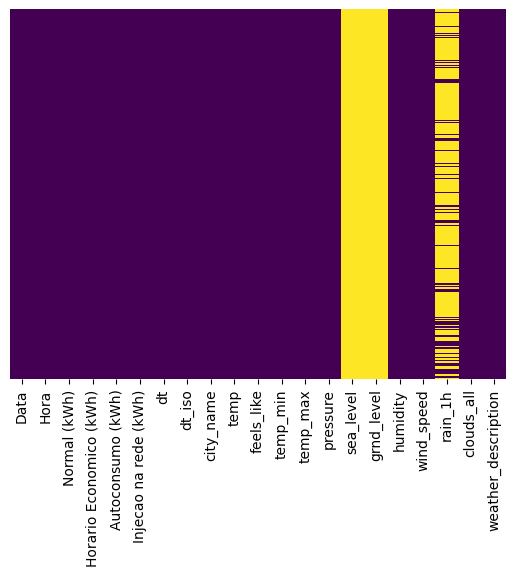

In [383]:
sns.heatmap(df_final_v1.isnull(),yticklabels= False,  cbar = False, cmap = 'viridis')

<Axes: >

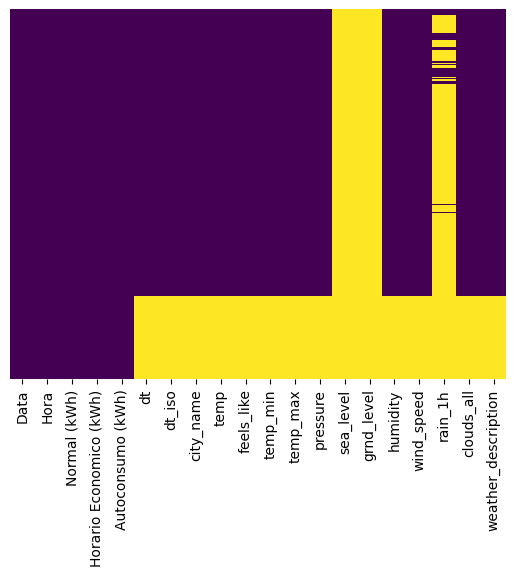

In [384]:
sns.heatmap(df_teste_v1.isnull(),yticklabels= False,  cbar = False, cmap = 'viridis')

Opção inner

In [385]:
df = df_final_v1
df

,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),Injecao na rede (kWh),dt,dt_iso,city_name,temp,...,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.000,0.000,0.0,None,1632873600,2021-09-29 00:00:00,local,13.97,...,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29,1,0.000,0.000,0.0,None,1632877200,2021-09-29 01:00:00,local,13.48,...,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29,2,0.000,0.000,0.0,None,1632880800,2021-09-29 02:00:00,local,12.93,...,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29,3,0.000,0.000,0.0,None,1632884400,2021-09-29 03:00:00,local,12.61,...,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29,4,0.000,0.000,0.0,None,1632888000,2021-09-29 04:00:00,local,12.61,...,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31,19,1.693,0.000,0.0,None,1672513200,2022-12-31 19:00:00,local,15.70,...,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
11012,2022-12-31,20,1.327,0.000,0.0,None,1672516800,2022-12-31 20:00:00,local,15.55,...,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
11013,2022-12-31,21,0.757,0.000,0.0,None,1672520400,2022-12-31 21:00:00,local,13.45,...,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
11014,2022-12-31,22,0.000,0.675,0.0,None,1672524000,2022-12-31 22:00:00,local,12.93,...,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [386]:
df_teste = df_teste_v1
df_teste

,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,2023-01-01 00:00:00,local,12.93,12.76,12.72,13.43,1019.0,NaN,NaN,95.0,2.02,3.72,100.0,moderate rain
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,2023-01-01 01:00:00,local,13.49,13.38,13.43,13.90,1018.0,NaN,NaN,95.0,2.18,3.26,100.0,moderate rain
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,2023-01-01 02:00:00,local,13.55,13.44,13.48,14.82,1017.0,NaN,NaN,95.0,2.88,2.44,100.0,moderate rain
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,2023-01-01 03:00:00,local,13.61,13.51,12.01,14.82,1016.0,NaN,NaN,95.0,3.63,1.74,100.0,moderate rain
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,2023-01-01 04:00:00,local,13.59,13.49,12.01,14.82,1015.0,NaN,NaN,95.0,4.58,1.13,100.0,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2252,2023-04-04,20,0.915,0.000,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2253,2023-04-04,21,0.479,0.000,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2254,2023-04-04,22,0.000,0.497,0.000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [387]:
df.duplicated().sum()

0

In [388]:
df.nunique()

Data                         459
Hora                          24
Normal (kWh)                1282
Horario Economico (kWh)      851
Autoconsumo (kWh)            752
Injecao na rede (kWh)          5
dt                         11016
dt_iso                     11016
city_name                      1
temp                        2382
feels_like                  2670
temp_min                     481
temp_max                     545
pressure                      41
sea_level                      0
grnd_level                     0
humidity                      82
wind_speed                   771
rain_1h                      367
clouds_all                   101
weather_description            8
dtype: int64

In [389]:
df['city_name']

0        local
1        local
2        local
3        local
4        local
         ...  
11011    local
11012    local
11013    local
11014    local
11015    local
Name: city_name, Length: 11016, dtype: object

In [390]:
df.drop(['city_name'], inplace=True, axis=1)
df_teste.drop(['city_name'], inplace=True, axis=1)
df.head()

,Data,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),Injecao na rede (kWh),dt,dt_iso,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00,13.97,13.54,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00,13.48,13.02,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00,12.93,12.47,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00,12.61,12.15,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00,12.61,12.17,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds


In [391]:
# Sea_level e grnd_level são ambas colunas vazias, portanto vamos fazer drop

df.drop(['sea_level'], inplace = True, axis = 1)
df.drop(['grnd_level'], inplace = True, axis = 1)

df_teste.drop(['sea_level'], inplace = True, axis = 1)
df_teste.drop(['grnd_level'], inplace = True, axis = 1)

In [392]:
print(df['rain_1h'].value_counts())
print('----------------------------------------------------------------------------------------------------------------')

# temos 10278 valores vazios para este dado
print(df[df['rain_1h'].isna()])

#subestituir os valores vazios por zero
df['rain_1h'] = df['rain_1h'].map(lambda x: 0 if pd.isna(x) else x)

df_teste['rain_1h'] = df_teste['rain_1h'].map(lambda x: 0 if pd.isna(x) else x)

rain_1h
0.12    69
0.16    57
0.15    54
0.14    54
0.11    51
        ..
6.36     1
3.54     1
3.89     1
3.65     1
4.07     1
Name: count, Length: 367, dtype: int64
----------------------------------------------------------------------------------------------------------------
             Data  Hora  Normal (kWh)  Horario Economico (kWh)  \
0      2021-09-29     0         0.000                      0.0   
1      2021-09-29     1         0.000                      0.0   
2      2021-09-29     2         0.000                      0.0   
3      2021-09-29     3         0.000                      0.0   
4      2021-09-29     4         0.000                      0.0   
...           ...   ...           ...                      ...   
11002  2022-12-31    10         1.074                      0.0   
11003  2022-12-31    11         0.360                      0.0   
11004  2022-12-31    12         0.402                      0.0   
11006  2022-12-31    14         1.060                      

<Axes: >

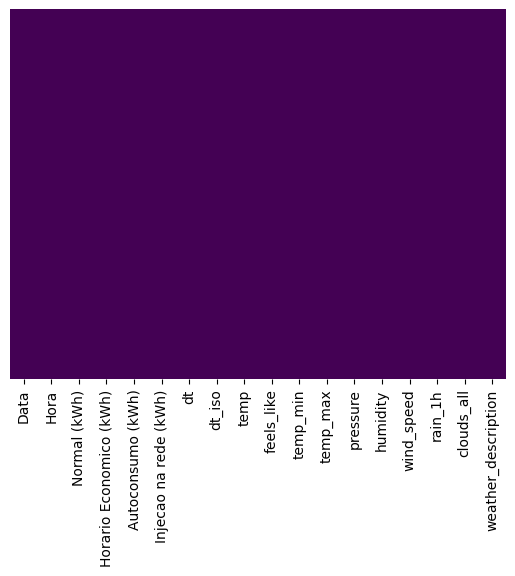

In [393]:
sns.heatmap(df.isnull(),yticklabels= False,  cbar = False, cmap = 'viridis')

<Axes: >

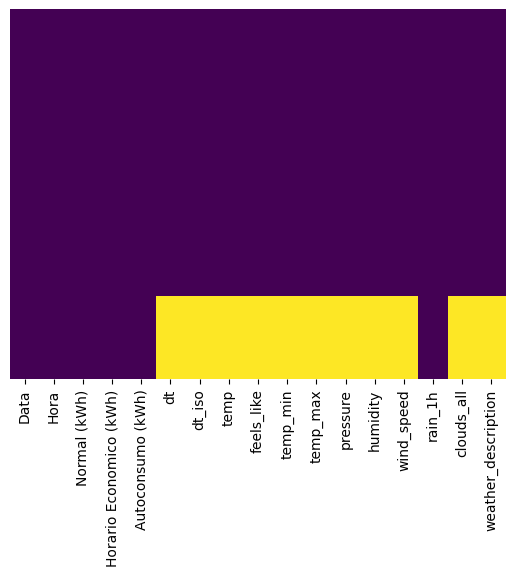

In [394]:
sns.heatmap(df_teste.isnull(),yticklabels= False,  cbar = False, cmap = 'viridis')

In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Data                     11016 non-null  object        
 1   Hora                     11016 non-null  int64         
 2   Normal (kWh)             11016 non-null  float64       
 3   Horario Economico (kWh)  11016 non-null  float64       
 4   Autoconsumo (kWh)        11016 non-null  float64       
 5   Injecao na rede (kWh)    11016 non-null  object        
 6   dt                       11016 non-null  int64         
 7   dt_iso                   11016 non-null  datetime64[ns]
 8   temp                     11016 non-null  float64       
 9   feels_like               11016 non-null  float64       
 10  temp_min                 11016 non-null  float64       
 11  temp_max                 11016 non-null  float64       
 12  pressure                 11016 n

In [396]:
df.drop(['Data'], inplace = True, axis = 1)
df.drop(['Hora'], inplace = True, axis = 1)

In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             11016 non-null  float64       
 1   Horario Economico (kWh)  11016 non-null  float64       
 2   Autoconsumo (kWh)        11016 non-null  float64       
 3   Injecao na rede (kWh)    11016 non-null  object        
 4   dt                       11016 non-null  int64         
 5   dt_iso                   11016 non-null  datetime64[ns]
 6   temp                     11016 non-null  float64       
 7   feels_like               11016 non-null  float64       
 8   temp_min                 11016 non-null  float64       
 9   temp_max                 11016 non-null  float64       
 10  pressure                 11016 non-null  int64         
 11  humidity                 11016 non-null  int64         
 12  wind_speed               11016 n

In [398]:
#df_Adriano = pd.read_csv("Portugal.csv",na_filter = True)

In [399]:
#df_Adriano['windspeed'] = pd.DataFrame ( map(lambda x: x/3.6, df_Adriano['windspeed']) )

In [400]:
"""# Filtrar as entradas relevantes no DataFrame H
Subset = df_Adriano[(df_Adriano['datetime'] >= '2023-03-15') & (df_Adriano['datetime'] <= '2023-04-04')]

# Definir 'Data' como índice para facilitar a combinação
Subset.set_index('datetime', inplace=True)
df_teste.set_index('Data', inplace=True)


# Preencher os valores ausentes em df_teste com os valores correspondentes de df_Adriano
df_teste['temp']       = df_teste['temp'].combine_first(Subset['temp'])
df_teste['humidity']   = df_teste['humidity'].combine_first(Subset['humidity'])
#df_teste['pressure']   = df_teste['pressure'].combine_first(Subset['sealevelpressure'])
df_teste['clouds_all'] = df_teste['clouds_all'].combine_first(Subset['cloudcover'])
#df_teste['wind_speed'] = df_teste['wind_speed'].combine_first(Subset['Windspeed'])

# Resetar o índice, se desejar
df_teste.reset_index(inplace=True)
"""


"# Filtrar as entradas relevantes no DataFrame H\nSubset = df_Adriano[(df_Adriano['datetime'] >= '2023-03-15') & (df_Adriano['datetime'] <= '2023-04-04')]\n\n# Definir 'Data' como índice para facilitar a combinação\nSubset.set_index('datetime', inplace=True)\ndf_teste.set_index('Data', inplace=True)\n\n\n# Preencher os valores ausentes em df_teste com os valores correspondentes de df_Adriano\ndf_teste['temp']       = df_teste['temp'].combine_first(Subset['temp'])\ndf_teste['humidity']   = df_teste['humidity'].combine_first(Subset['humidity'])\n#df_teste['pressure']   = df_teste['pressure'].combine_first(Subset['sealevelpressure'])\ndf_teste['clouds_all'] = df_teste['clouds_all'].combine_first(Subset['cloudcover'])\n#df_teste['wind_speed'] = df_teste['wind_speed'].combine_first(Subset['Windspeed'])\n\n# Resetar o índice, se desejar\ndf_teste.reset_index(inplace=True)\n"

In [401]:
#df['Year']   = df['dt_iso'].dt.year
df['Month']  = df['dt_iso'].dt.month
df['Day']    = df['dt_iso'].dt.day

df['Hour']   = df['dt_iso'].dt.hour
df['Minute'] = df['dt_iso'].dt.minute
df['Second'] = df['dt_iso'].dt.second

df_teste['Data'] = pd.to_datetime((df_teste["Data"]))
df_teste['Data'].dt.strftime('%Y-%m-%d')

#df_teste['Year']   = df_teste['Data'].dt.year
df_teste['Month']  = df_teste['Data'].dt.month
df_teste['Day']    = df_teste['Data'].dt.day
df_teste['Hour']   = df_teste['Hora']

In [402]:
df['Dia da Semana'] = df['dt_iso'].map(lambda x: x.weekday())
#df['Friado'] = 
df_teste['Dia da Semana'] = df_teste['Data'].map(lambda x: x.weekday())
df_teste['Dia da Semana'].value_counts()

Dia da Semana
6    336
0    336
1    336
2    312
3    312
4    312
5    312
Name: count, dtype: int64

In [403]:
def obter_estacao(do):
    if (do.month == 3 and do.day >= 20) or do.month == 4 or do.month == 5 or (do.month == 6 and do.day <21):
        return 1  # Primavera
    if (do.month == 6 and do.day >= 21) or do.month == 7 or do.month == 8 or (do.month == 9 and do.day <22):
        return 0  # Verão
    if (do.month == 9 and do.day >= 22) or do.month == 10 or do.month == 11 or (do.month == 12 and do.day <22):
        return 2  # Outono
    else:
        return 3  # Inverno

In [404]:
"""# verão = 0, primavera = 1, outono = 2, inverno = 3
df      ['estacao do ano'] = df['dt_iso'].apply(obter_estacao)
df_teste['estacao do ano'] = df_teste['Data'].apply(obter_estacao)

df['estacao do ano'].astype('category')
df_teste['estacao do ano'].astype('category')
df['estacao do ano'].value_counts()"""

"# verão = 0, primavera = 1, outono = 2, inverno = 3\ndf      ['estacao do ano'] = df['dt_iso'].apply(obter_estacao)\ndf_teste['estacao do ano'] = df_teste['Data'].apply(obter_estacao)\n\ndf['estacao do ano'].astype('category')\ndf_teste['estacao do ano'].astype('category')\ndf['estacao do ano'].value_counts()"

In [405]:
# Criando a coluna 'feriado' com valores iniciais iguais a 0
df['feriado'] = 0

# Lista de feriados fixos
feriados_fixos = ['01-01', '04-25', '05-01', '06-10', '08-15', '10-05', '11-01', '12-01', '12-08', '12-25']

# Adicionando feriados fixos
for feriado in feriados_fixos:
    df.loc[df['dt_iso'].dt.strftime('%m-%d') == feriado, 'feriado'] = 1

# Adicionando Sexta-feira Santa
sexta_santa_dates = ['2021-04-02', '2022-04-15']
df.loc[df['dt_iso'].isin(sexta_santa_dates), 'feriado'] = 1

# Adicionando Páscoa
pascoa_dates = ['2021-04-04', '2022-03-27']
df.loc[df['dt_iso'].isin(pascoa_dates), 'feriado'] = 1

df['feriado'].value_counts()

feriado
0    10654
1      362
Name: count, dtype: int64

In [406]:
# Criando a coluna 'feriado' com valores iniciais iguais a 0
df_teste['feriado'] = 0

# Lista de feriados fixos
feriados_fixos = ['01-01', '04-25', '05-01', '06-10', '08-15', '10-05', '11-01', '12-01', '12-08', '12-25']

# Adicionando feriados fixos
for feriado in feriados_fixos:
    df_teste.loc[df_teste['Data'].dt.strftime('%m-%d') == feriado, 'feriado'] = 1

# Adicionando Sexta-feira Santa
sexta_santa_dates = ['2023-04-07']
df_teste.loc[df_teste['Data'].isin(sexta_santa_dates), 'feriado'] = 1

# Adicionando Páscoa
pascoa_dates = ['2023-04-16']
df_teste.loc[df_teste['Data'].isin(pascoa_dates), 'feriado'] = 1

df_teste['feriado'].value_counts()

feriado
0    2232
1      24
Name: count, dtype: int64

In [407]:
df_teste.drop(['Data'], inplace = True, axis = 1)
df_teste.drop(['Hora'], inplace = True, axis = 1)

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             11016 non-null  float64       
 1   Horario Economico (kWh)  11016 non-null  float64       
 2   Autoconsumo (kWh)        11016 non-null  float64       
 3   Injecao na rede (kWh)    11016 non-null  object        
 4   dt                       11016 non-null  int64         
 5   dt_iso                   11016 non-null  datetime64[ns]
 6   temp                     11016 non-null  float64       
 7   feels_like               11016 non-null  float64       
 8   temp_min                 11016 non-null  float64       
 9   temp_max                 11016 non-null  float64       
 10  pressure                 11016 non-null  int64         
 11  humidity                 11016 non-null  int64         
 12  wind_speed               11016 n

In [409]:
df.drop('dt_iso', inplace=True, axis=1)
df_teste.drop('dt_iso', inplace=True, axis=1)

In [410]:
df['weather_description'].value_counts()

weather_description
sky is clear            3010
overcast clouds         2430
light rain              1662
broken clouds           1413
scattered clouds        1148
few clouds               731
moderate rain            562
heavy intensity rain      60
Name: count, dtype: int64

In [411]:
# Criar os atributos binários
#df['sky is clear']             = ( df['weather_description'].str.contains('sky is clear') ).astype(int)
df['overcast clouds']          = ( df['weather_description'].str.contains('overcast clouds') ).astype(int)
df['light rain']               = ( df['weather_description'].str.contains('light rain') ).astype(int)
df['broken clouds']            = ( df['weather_description'].str.contains('broken clouds') ).astype(int)
df['scattered clouds']         = ( df['weather_description'].str.contains('scattered clouds') ).astype(int)
df['few clouds']               = ( df['weather_description'].str.contains('few clouds') ).astype(int)
df['moderate rain']            = ( df['weather_description'].str.contains('moderate rain') ).astype(int)
df['heavy intensity rain']     = ( df['weather_description'].str.contains('heavy intensity rain') ).astype(int)

#df_teste['sky is clear']             = ( df['weather_description'].str.contains('sky is clear') ).astype(int)
df_teste['overcast clouds']          = ( df['weather_description'].str.contains('overcast clouds') ).astype(int)
df_teste['light rain']               = ( df['weather_description'].str.contains('light rain') ).astype(int)
df_teste['broken clouds']            = ( df['weather_description'].str.contains('broken clouds') ).astype(int)
df_teste['scattered clouds']         = ( df['weather_description'].str.contains('scattered clouds') ).astype(int)
df_teste['few clouds']               = ( df['weather_description'].str.contains('few clouds') ).astype(int)
df_teste['moderate rain']            = ( df['weather_description'].str.contains('moderate rain') ).astype(int)
df_teste['heavy intensity rain']     = ( df['weather_description'].str.contains('heavy intensity rain') ).astype(int)



In [412]:
df.drop(['weather_description'], inplace = True, axis = 1)

df_teste.drop(['weather_description'], inplace = True, axis = 1)

In [413]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Normal (kWh)             11016 non-null  float64
 1   Horario Economico (kWh)  11016 non-null  float64
 2   Autoconsumo (kWh)        11016 non-null  float64
 3   Injecao na rede (kWh)    11016 non-null  object 
 4   dt                       11016 non-null  int64  
 5   temp                     11016 non-null  float64
 6   feels_like               11016 non-null  float64
 7   temp_min                 11016 non-null  float64
 8   temp_max                 11016 non-null  float64
 9   pressure                 11016 non-null  int64  
 10  humidity                 11016 non-null  int64  
 11  wind_speed               11016 non-null  float64
 12  rain_1h                  11016 non-null  float64
 13  clouds_all               11016 non-null  int64  
 14  Month                 

In [414]:
df.nunique()

Normal (kWh)                1282
Horario Economico (kWh)      851
Autoconsumo (kWh)            752
Injecao na rede (kWh)          5
dt                         11016
temp                        2382
feels_like                  2670
temp_min                     481
temp_max                     545
pressure                      41
humidity                      82
wind_speed                   771
rain_1h                      368
clouds_all                   101
Month                         12
Day                           31
Hour                          24
Minute                         1
Second                         1
Dia da Semana                  7
feriado                        2
overcast clouds                2
light rain                     2
broken clouds                  2
scattered clouds               2
few clouds                     2
moderate rain                  2
heavy intensity rain           2
dtype: int64

In [415]:
for col in df:
    
    print (df[col].value_counts())
    print("----------------------------------------------------------------")

Normal (kWh)
0.000    6018
0.001      23
0.008      19
0.252      17
0.016      17
         ... 
1.479       1
1.024       1
0.839       1
0.832       1
1.327       1
Name: count, Length: 1282, dtype: int64
----------------------------------------------------------------
Horario Economico (kWh)
0.000    6813
0.263      34
0.256      31
0.321      29
0.260      27
         ... 
1.811       1
1.571       1
1.440       1
1.675       1
0.702       1
Name: count, Length: 851, dtype: int64
----------------------------------------------------------------
Autoconsumo (kWh)
0.000    5657
0.001      67
0.002      57
0.004      48
0.003      38
         ... 
0.901       1
0.808       1
0.624       1
0.771       1
0.848       1
Name: count, Length: 752, dtype: int64
----------------------------------------------------------------
Injecao na rede (kWh)
None         7777
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64
--------------------------------

In [416]:
print(df['clouds_all'].value_counts())

clouds_all
100    2065
0      1791
99      406
1       322
98      302
       ... 
59       41
24       38
28       37
31       37
25       29
Name: count, Length: 101, dtype: int64


In [417]:
# dt é um time stamp em Unix time ou Epoch time. 
# O Unix time é uma forma de medir o tempo como o número de segundos decorridos desde a meia-noite UTC 
# (Coordinated Universal Time) de 1º de janeiro de 1970, excluindo segundos bissextos. 
# Cada número inteiro representa um segundo adicional.
# ou seja poderiamos converter para o formato ano-mês-dia-hora-minuto mas não é precisso pois já temos esse dados, ou seja 
# podemos dar drop

df.drop('dt', inplace=True, axis=1)

df_teste.drop('dt', inplace=True, axis=1)

In [418]:
df['Injecao na rede (kWh)'].value_counts()

Injecao na rede (kWh)
None         7777
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64

In [419]:
#fazer label encoding

categoria_para_numero = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
df['Injecao na rede (kWh)'] = df['Injecao na rede (kWh)'].map(categoria_para_numero)

In [420]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Normal (kWh)             11016 non-null  float64
 1   Horario Economico (kWh)  11016 non-null  float64
 2   Autoconsumo (kWh)        11016 non-null  float64
 3   Injecao na rede (kWh)    11016 non-null  int64  
 4   temp                     11016 non-null  float64
 5   feels_like               11016 non-null  float64
 6   temp_min                 11016 non-null  float64
 7   temp_max                 11016 non-null  float64
 8   pressure                 11016 non-null  int64  
 9   humidity                 11016 non-null  int64  
 10  wind_speed               11016 non-null  float64
 11  rain_1h                  11016 non-null  float64
 12  clouds_all               11016 non-null  int64  
 13  Month                    11016 non-null  int32  
 14  Day                   

In [421]:
df.drop('Minute', inplace=True, axis=1)
df.drop('Second', inplace=True, axis=1)

In [422]:
df.nunique()

Normal (kWh)               1282
Horario Economico (kWh)     851
Autoconsumo (kWh)           752
Injecao na rede (kWh)         5
temp                       2382
feels_like                 2670
temp_min                    481
temp_max                    545
pressure                     41
humidity                     82
wind_speed                  771
rain_1h                     368
clouds_all                  101
Month                        12
Day                          31
Hour                         24
Dia da Semana                 7
feriado                       2
overcast clouds               2
light rain                    2
broken clouds                 2
scattered clouds              2
few clouds                    2
moderate rain                 2
heavy intensity rain          2
dtype: int64

In [423]:
#correlação com temp é quase 1 logo devemos apaga-los

df_teste.drop('feels_like', inplace=True, axis=1)
df_teste.drop('temp_min', inplace=True, axis=1)
df_teste.drop('temp_max', inplace=True, axis=1)

In [424]:
#correlação com temp é quase 1 logo devemos apaga-los

df.drop('feels_like', inplace=True, axis=1)
df.drop('temp_min', inplace=True, axis=1)
df.drop('temp_max', inplace=True, axis=1)

In [425]:
"""df['pressure']   = (df['pressure'] - df['pressure'].min()) / (df['pressure'].max() - df['pressure'].min())
df['humidity']   = (df['humidity'] - df['humidity'].min()) / (df['humidity'].max() - df['humidity'].min())
df['clouds_all'] = (df['clouds_all'] - df['clouds_all'].min()) / (df['clouds_all'].max() - df['clouds_all'].min())
df['temp']       = (df['temp'] - df['temp'].min()) / (df['temp'].max() - df['temp'].min())
df['Hour']       = (df['Hour'] - df['Hour'].min()) / (df['Hour'].max() - df['Hour'].min())
df.describe()"""

"df['pressure']   = (df['pressure'] - df['pressure'].min()) / (df['pressure'].max() - df['pressure'].min())\ndf['humidity']   = (df['humidity'] - df['humidity'].min()) / (df['humidity'].max() - df['humidity'].min())\ndf['clouds_all'] = (df['clouds_all'] - df['clouds_all'].min()) / (df['clouds_all'].max() - df['clouds_all'].min())\ndf['temp']       = (df['temp'] - df['temp'].min()) / (df['temp'].max() - df['temp'].min())\ndf['Hour']       = (df['Hour'] - df['Hour'].min()) / (df['Hour'].max() - df['Hour'].min())\ndf.describe()"

In [426]:
X = df.drop('Injecao na rede (kWh)', axis = 1)
y = df['Injecao na rede (kWh)']

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 2022)

In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Normal (kWh)             11016 non-null  float64
 1   Horario Economico (kWh)  11016 non-null  float64
 2   Autoconsumo (kWh)        11016 non-null  float64
 3   Injecao na rede (kWh)    11016 non-null  int64  
 4   temp                     11016 non-null  float64
 5   pressure                 11016 non-null  int64  
 6   humidity                 11016 non-null  int64  
 7   wind_speed               11016 non-null  float64
 8   rain_1h                  11016 non-null  float64
 9   clouds_all               11016 non-null  int64  
 10  Month                    11016 non-null  int32  
 11  Day                      11016 non-null  int32  
 12  Hour                     11016 non-null  int32  
 13  Dia da Semana            11016 non-null  int64  
 14  feriado               

In [429]:
df_teste.head

<bound method NDFrame.head of       Normal (kWh)  Horario Economico (kWh)  Autoconsumo (kWh)   temp  \
0            0.000                    0.467              0.000  12.93   
1            0.000                    0.577              0.000  13.49   
2            0.000                    0.346              0.000  13.55   
3            0.000                    0.270              0.000  13.61   
4            0.000                    0.252              0.000  13.59   
...            ...                      ...                ...    ...   
2251         0.953                    0.000              0.012    NaN   
2252         0.915                    0.000              0.000    NaN   
2253         0.479                    0.000              0.000    NaN   
2254         0.000                    0.497              0.000    NaN   
2255         0.000                    0.487              0.000    NaN   

      pressure  humidity  wind_speed  rain_1h  clouds_all  Month  ...  Hour  \
0       1019.0

<Axes: >

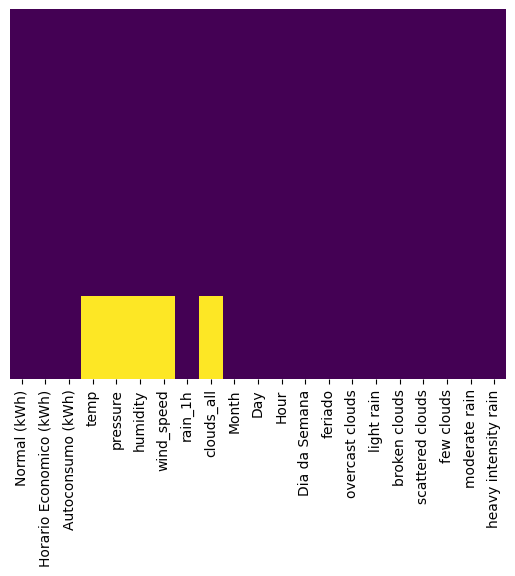

In [430]:
sns.heatmap(df_teste.isnull(),yticklabels= False,  cbar = False, cmap = 'viridis')

In [431]:
df_teste.nunique()

Normal (kWh)               709
Horario Economico (kWh)    490
Autoconsumo (kWh)          485
temp                       889
pressure                    31
humidity                    71
wind_speed                 512
rain_1h                    121
clouds_all                  99
Month                        4
Day                         31
Hour                        24
Dia da Semana                7
feriado                      2
overcast clouds              2
light rain                   2
broken clouds                2
scattered clouds             2
few clouds                   2
moderate rain                2
heavy intensity rain         2
dtype: int64

In [432]:
df.nunique()

Normal (kWh)               1282
Horario Economico (kWh)     851
Autoconsumo (kWh)           752
Injecao na rede (kWh)         5
temp                       2382
pressure                     41
humidity                     82
wind_speed                  771
rain_1h                     368
clouds_all                  101
Month                        12
Day                          31
Hour                         24
Dia da Semana                 7
feriado                       2
overcast clouds               2
light rain                    2
broken clouds                 2
scattered clouds              2
few clouds                    2
moderate rain                 2
heavy intensity rain          2
dtype: int64

In [433]:
corr_matrix = df_teste.corr()
f,ax =  plt.subplots(figsize = (100,100))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, square=True)

<Axes: >

In [434]:
corr_matrix = df.corr()
f,ax =  plt.subplots(figsize = (100,100))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, square=True)

<Axes: >

In [435]:
xgb_model = XGBClassifier(objective = 'reg:squareaerror')

In [436]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [437]:
SaveModel("Modelos_Carlos/xgb_classifier_Carlos_v10", xgb_model)
model = UseModel("Modelos_Carlos/xgb_classifier_Carlos_v10")

In [438]:
xgb_sore = model.score(X_test,y_test)

In [439]:
print("Acuracy :)) = %.2f%%" %(xgb_sore * 100) )

Acuracy :)) = 87.56%


In [440]:
xgb_predicions = model.predict(X_test)

In [441]:
print( classification_report(y_test, xgb_predicions) )

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2311
           1       0.44      0.23      0.30       153
           2       0.58      0.67      0.63       315
           3       0.68      0.73      0.70       331
           4       0.78      0.73      0.76       195

    accuracy                           0.88      3305
   macro avg       0.69      0.67      0.67      3305
weighted avg       0.87      0.88      0.87      3305



In [442]:
 #kaggleMaker(df_teste,model,10)